# 0.0 Imports

In [64]:
import pandas as pd
import numpy  as np

import inflection
import math
import datetime

import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML

## 0.1 Helper functions

In [65]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.set_option('max_columns', None, "max_rows", 50)
    pd.options.display.max_rows = 999
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cramer_v(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    # é necessário os valores da cm como uma matriz
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 =stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))

In [3]:
jupyter_settings()
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option( 'display.expand_frame_repr', False )

#plt.style.use( 'bmh' )
#plt.rcParams['figure.figsize'] = [25, 12]
#plt.rcParams['font.size'] = 24
#sns.set()


## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

# 1.0 Data description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columns


In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
df1.isna().sum() * 100 / df1.shape[0]

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

## 1.5 Fillout NA 

In [11]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                          
#promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval       
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64', 'int32', 'float32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]', 'int32', 'float32'])

### 1.7.1 Numerical attributes

In [15]:
#Central tendency - mean & median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.min() - x.max())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,-1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,-6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,-41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,-7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,-1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,-1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,-1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,-199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,-11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,-115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Gabriel\anaconda3\envs\dsemproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

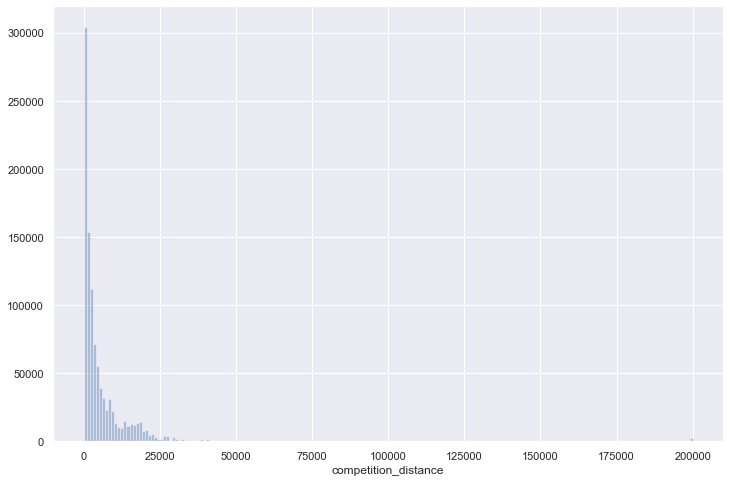

In [16]:
sns.distplot(df1['competition_distance'], kde=False, bins=200)

### 1.7.2 Categorical attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

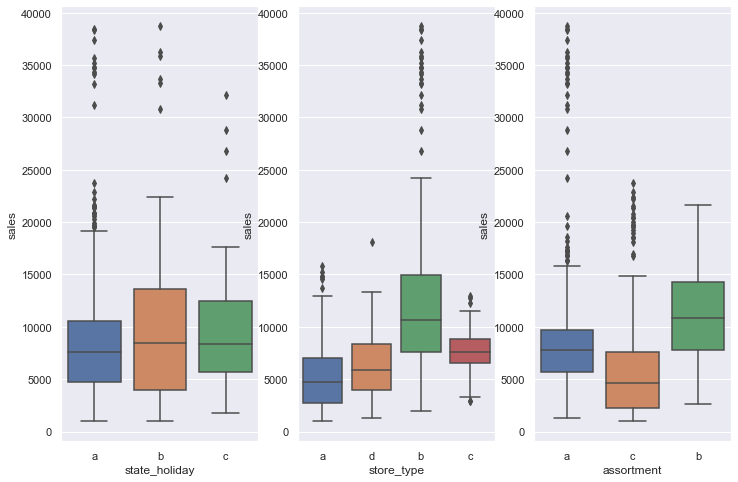

In [18]:
aux = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipoteses

## 2.2 Criação de Hipoteses

## 2.3 Lista final de Hipoteses

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais

5. Lojas com mais dias de promoção deveriam vender mais.

6. Lojas com mais promoções consecutivas deveriam vender mais.

7. Lojas abertas durante o feriado de Natal deveriam vender mais.

8. Lojas deveriam vender mais ao longo dos anos.

9. Lojas deveriam vender mais no segundo semestre do ano.

10. Lojas deveriam vender mais depois do dia 10 de cada mês.

11. Lojas deveriam vender menos aos finais de semana.

12. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )

# promo time week = date - promo since/7 (pega dia)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')


#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


# 3.0 - Filtragem de variáveis

In [21]:
df3 = df2.copy()

In [22]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Filtragem das linhas



In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [25]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 - Análise exploratória dos dados - EDA

In [26]:
df4 = df3.copy()

## 4.1 - Análise univariada

### 4.1.1 Response variable

C:\Users\Gabriel\anaconda3\envs\dsemproducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

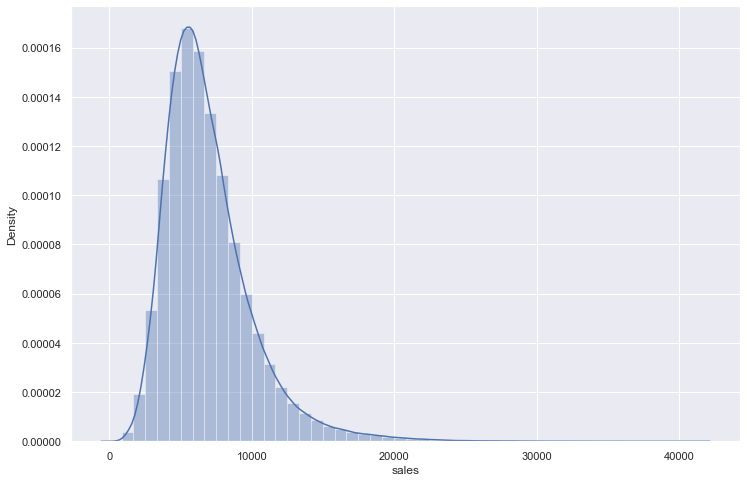

In [27]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical variable

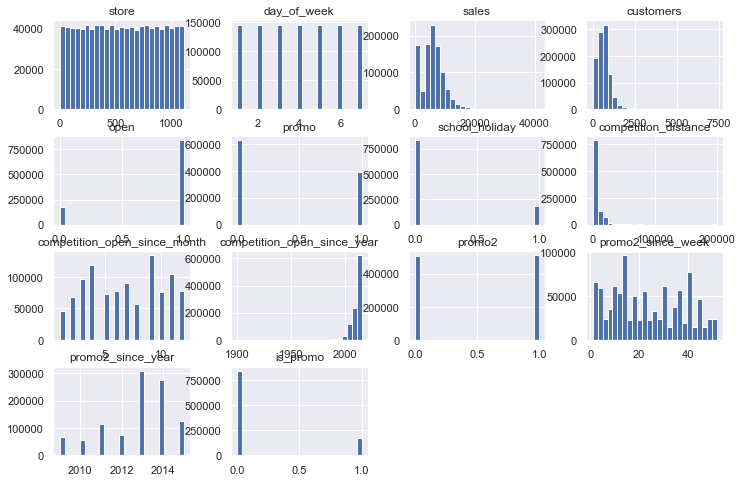

In [28]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

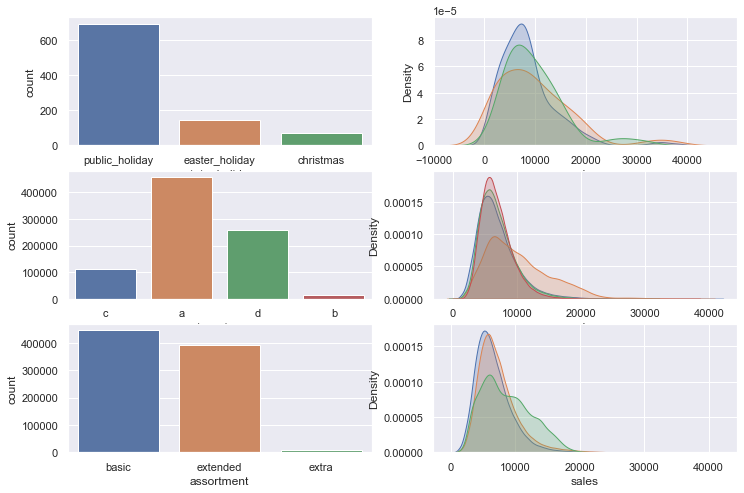

In [29]:
#state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(x=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(x=df4[df4['state_holiday'] == 'christmas']['sales'], label='public_holiday', shade=True)

#store type
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(x=df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(x=df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(x=df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(x=df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(x=df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(x=df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(x=df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 - Análise bivariada

### 4.2.1 H1 - Lojas com maior sortimentos deveriam vender mais.

Depende, no geral é falsa mas proporcionalmente as lojas com maior sortimento vendem mais

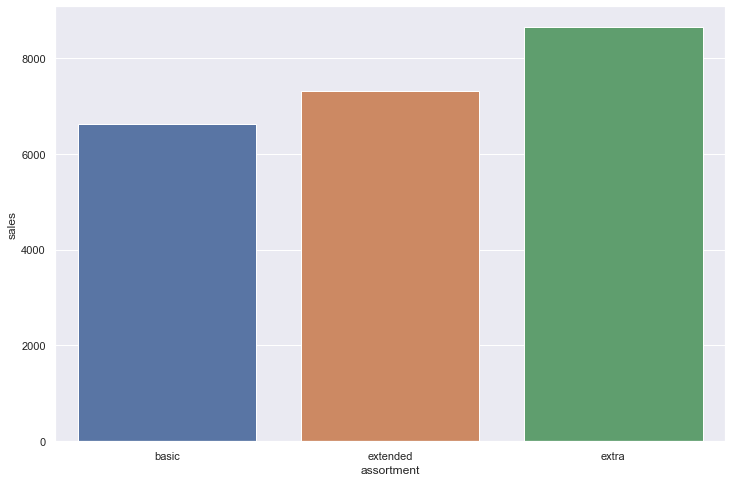

In [30]:
#Mean all sales per assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

sns.barplot(x='assortment', y='sales', data=aux1);

Lets see those sells over the time if we see something different

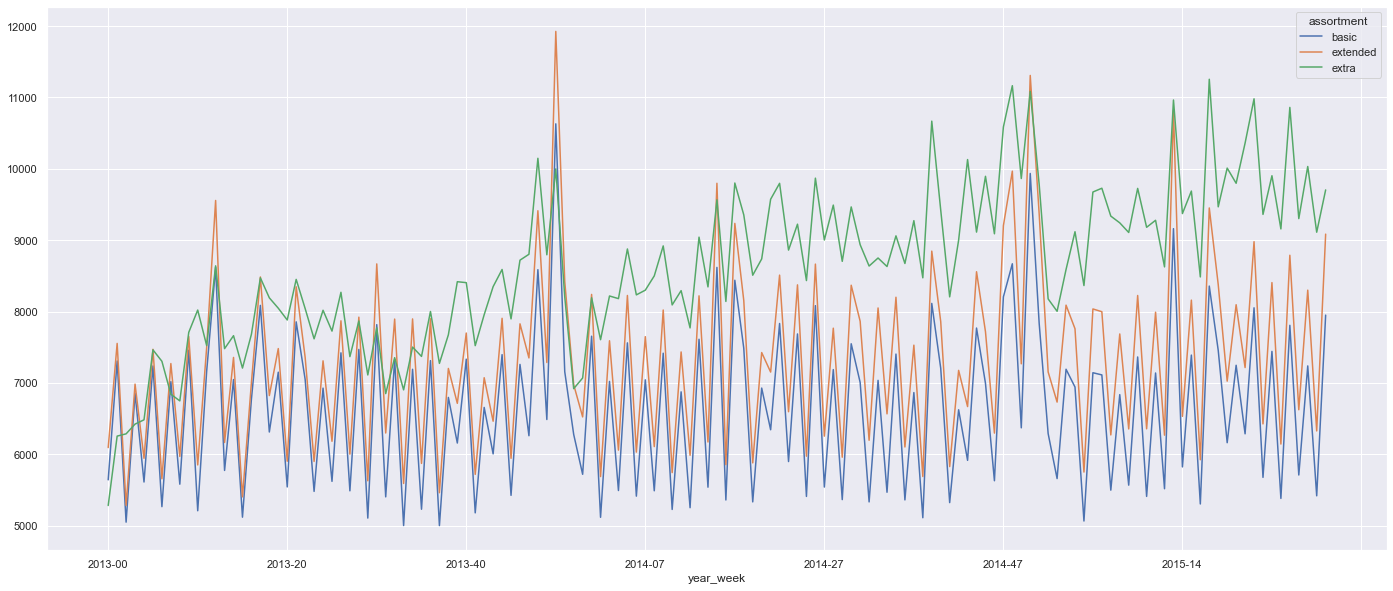

In [31]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(24,10));

Over the year we can see that stores with extra assortment sells more in the mean and we can notice a peak between 2013-2014, let's try to understand what happended that week

In [32]:
aux2[(aux2['sales'] > 9500) & (aux2['year_week'] < '2014-07')]

,year_week,assortment,sales
37,2013-12,extended,9556.211306
146,2013-48,extra,10147.174603
150,2013-50,basic,10629.796130
151,2013-50,extended,11924.758174
152,2013-50,extra,9998.380952


Well, we can see that happened in the 50th week, it's between christmas holiday and new-year. Let's see if those higher sells happen in every last weeks of the year

In [33]:
aux2[aux2['sales'] > 10000]

,year_week,assortment,sales
146,2013-48,extra,10147.174603
150,2013-50,basic,10629.796130
151,2013-50,extended,11924.758174
278,2014-39,extra,10667.571429
290,2014-43,extra,10129.410714
302,2014-47,extra,10585.196429
305,2014-48,extra,11164.303571
310,2014-50,extended,11307.897597
311,2014-50,extra,11084.696429
358,2015-13,extended,10822.025571


So we can notice that between 47th-50th week of the year the stores have an increase in sells

### 4.2.2 H2. Lojas com competidores mais próximos deveriam vender menos.

False, neither sell more or less

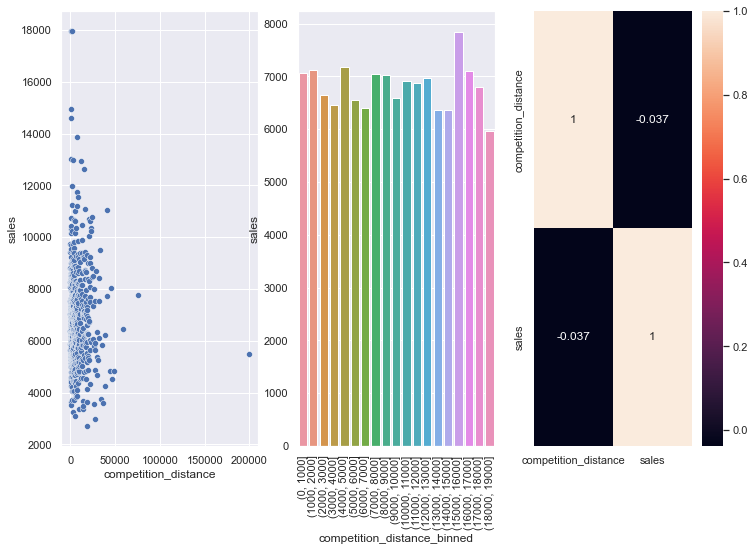

In [34]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr('pearson'), annot=True);

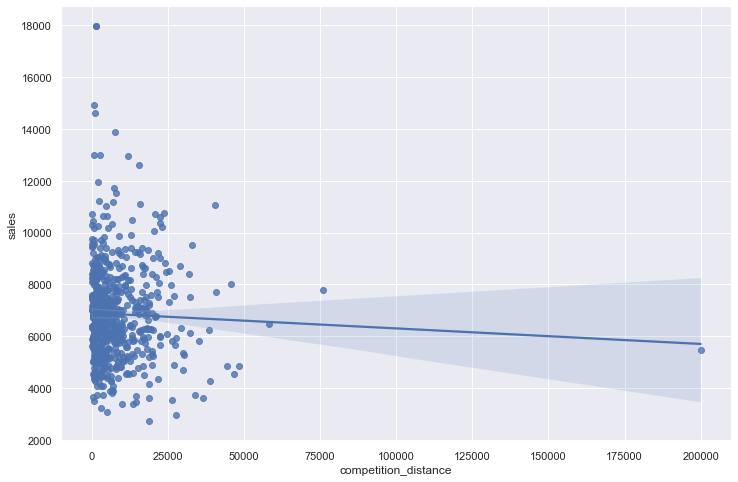

In [35]:
sns.regplot(x='competition_distance', y='sales', data=aux1);

We can see that there is no correlation between competition distance and sells, so **neither stores with closer competitons sells more or less**

### 4.2.3 H3. Lojas com promoções ativas por mais tempo deveriam vender mais.

Yes, in the extended promotions we can see an increase in sales

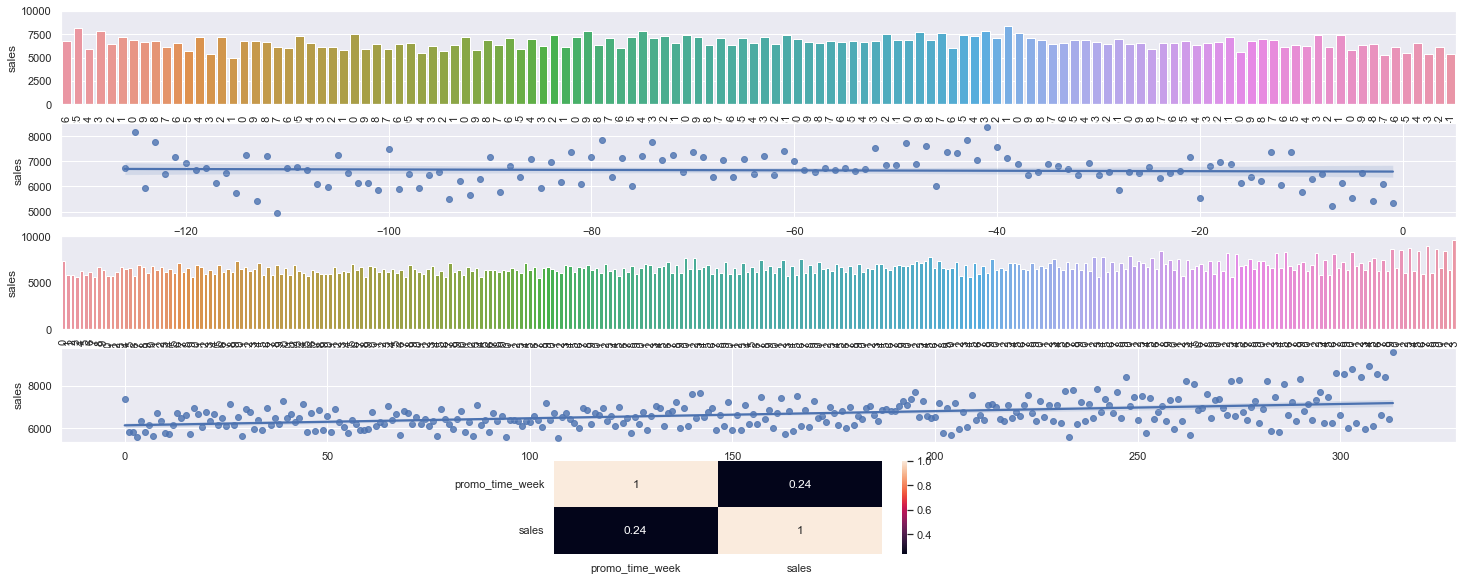

In [36]:
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
aux1 = aux[aux['promo_time_week'] < 0] # no extended promo
aux2 = aux[aux['promo_time_week'] >= 0] # with promo extended

grid = GridSpec(5,3)
plt.figure(figsize=(25,10))

plt.subplot(grid[0,:])
sns.barplot(x='promo_time_week', y='sales', data=aux1);
plt.ylim(0,10000)
plt.xticks(rotation=90);

plt.subplot(grid[1,:])
sns.regplot(x='promo_time_week', y='sales', data=aux1);

plt.subplot(grid[2,:])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[3,:])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[4,1])
sns.heatmap(aux.corr('pearson'), annot=True);

### 4.2.4 H4. Lojas com mais dias de promoção deveriam vender mais

### 4.2.5 H5. Lojas com mais promoções consecutivas deveriam vender mais.

False, stores with extended promo sells less in mean

In [37]:
df4[['promo', 'promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


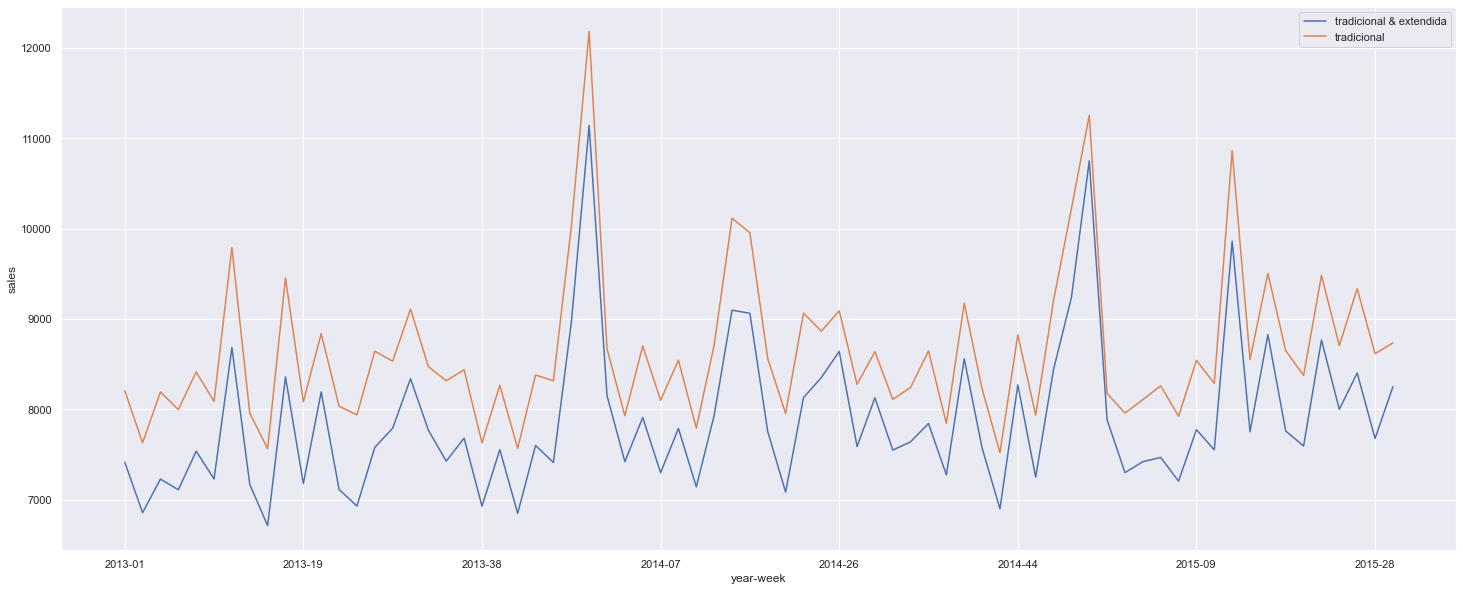

In [38]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux1.set_index('year_week', inplace=True)
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.set_index('year_week', inplace=True)
aux2.plot(ax=ax, figsize=(25,10), xlabel='year-week', ylabel='sales')

ax.legend(labels=['tradicional & extendida', 'tradicional'])

### 4.2.6 H6. Lojas abertas durante o feriado de Natal deveriam vender mais.

Yes, but easter holiday sells a little bit more than christmas, so we can say that in christmas and easter stores sells more in mean than public holidays

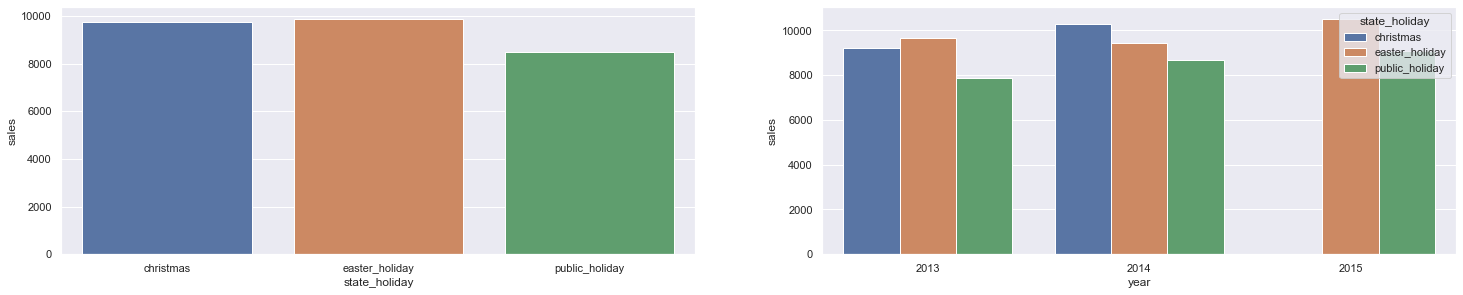

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

grid = GridSpec(2,2)
plt.figure(figsize=(25,10))

plt.subplot(grid[0,0])
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(grid[0,1])
aux2 = aux[['state_holiday', 'sales', 'year']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### 4.2.7  H9. Lojas deveriam vender mais ao longo dos anos.

Yes, in mean we have more sales over the years

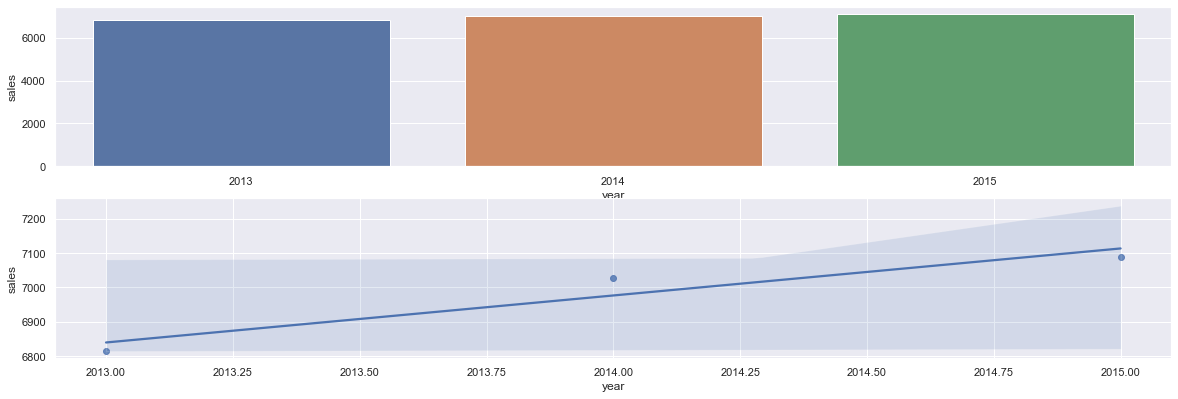

In [40]:
grid = GridSpec(3,1)
plt.figure(figsize=(20,10))

aux = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot(grid[0,0])
sns.barplot(x='year', y='sales', data=aux);

plt.subplot(grid[1,0])
sns.regplot(x='year', y='sales', data=aux);

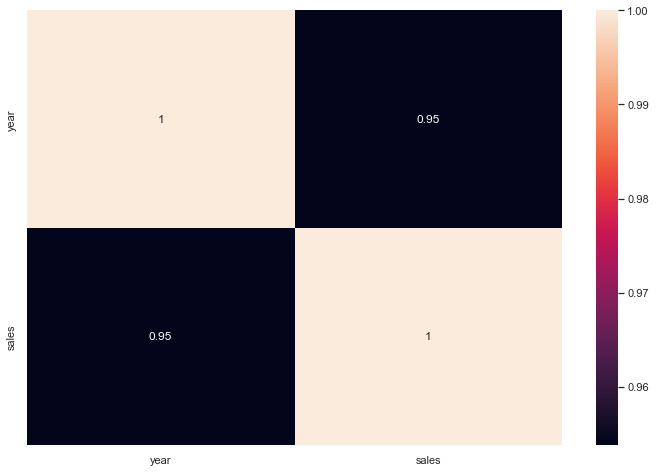

In [41]:
sns.heatmap(aux.corr('pearson'), annot=True);

### 4.2.8 H10. Lojas deveriam vender mais no segundo semestre do ano.

Yes but it's imprecisely, sell in second semester are a bit higher than first semester

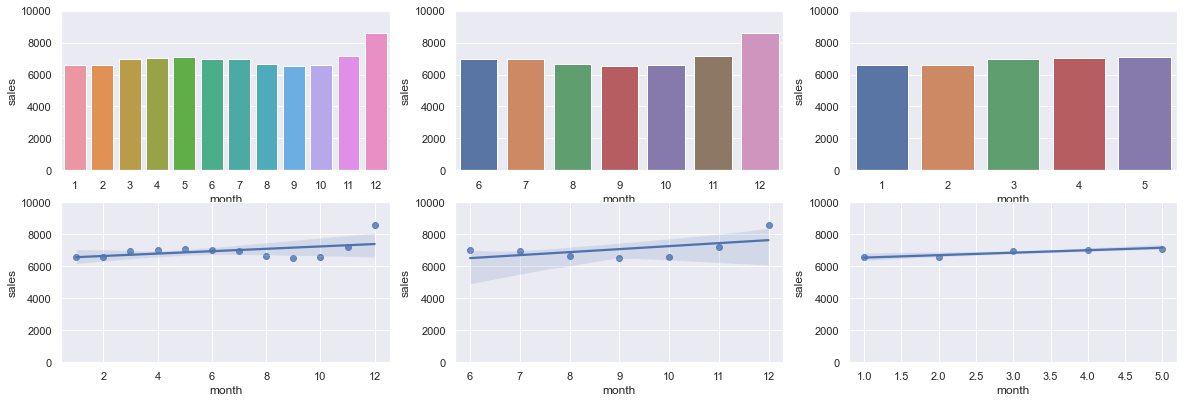

In [42]:
grid = GridSpec(3,3)
plt.figure(figsize=(20,10))

aux = df4[['month', 'sales']].groupby('month').mean().reset_index()
aux2 = aux[aux['month'] >= 6]
aux3 = aux[aux['month'] < 6]

plt.subplot(grid[0,0])
sns.barplot(x='month', y='sales', data=aux, );
plt.ylim(0,10000);

plt.subplot(grid[1,0])
sns.regplot(x='month', y='sales', data=aux);
plt.ylim(0,10000);

plt.subplot(grid[0,1])
sns.barplot(x='month', y='sales', data=aux2);
plt.ylim(0,10000);

plt.subplot(grid[1,1])
sns.regplot(x='month', y='sales', data=aux2);
plt.ylim(0,10000);

plt.subplot(grid[0,2])
sns.barplot(x='month', y='sales', data=aux3);
plt.ylim(0,10000);

plt.subplot(grid[1,2])
sns.regplot(x='month', y='sales', data=aux3);
plt.ylim(0,10000);

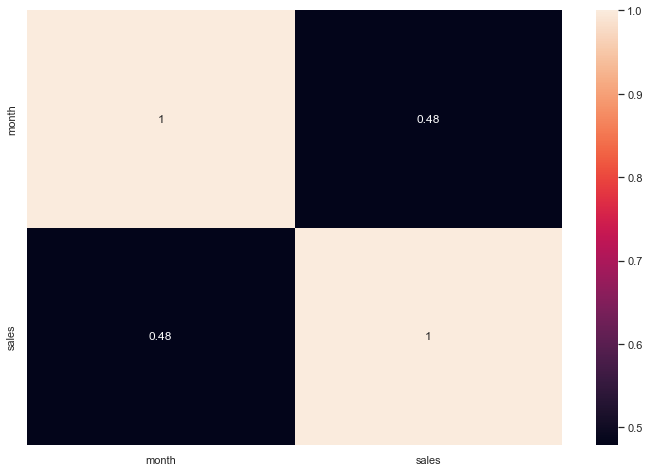

In [43]:
sns.heatmap(aux.corr('pearson'), annot=True);

### 4.2.8 H11. Lojas deveriam vender mais depois do dia 10 de cada mês

False, stores sell less after 10 days

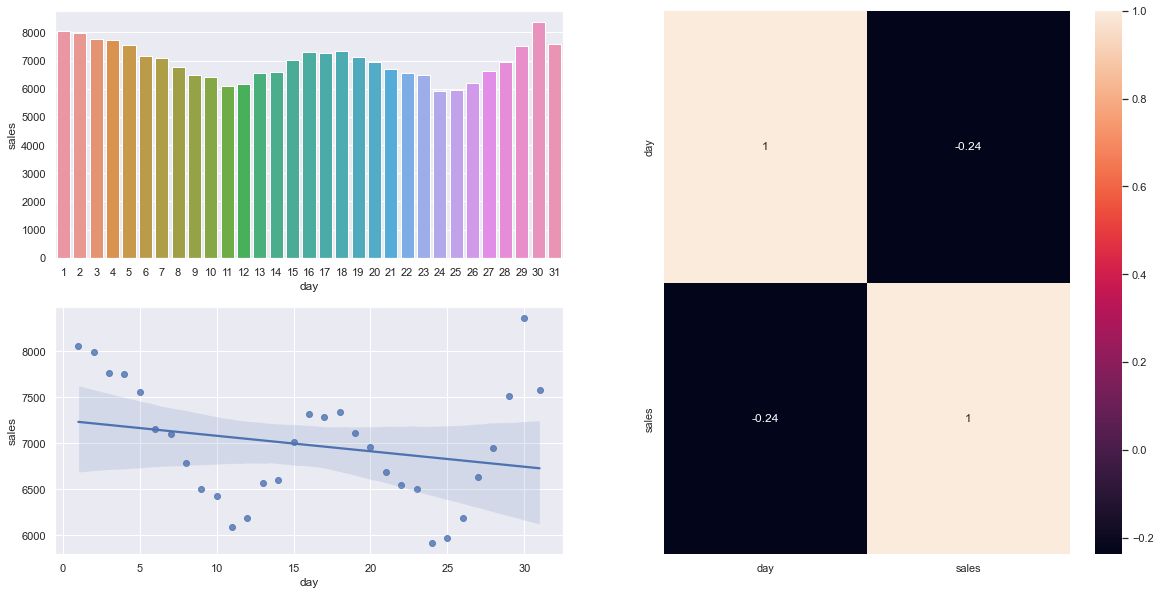

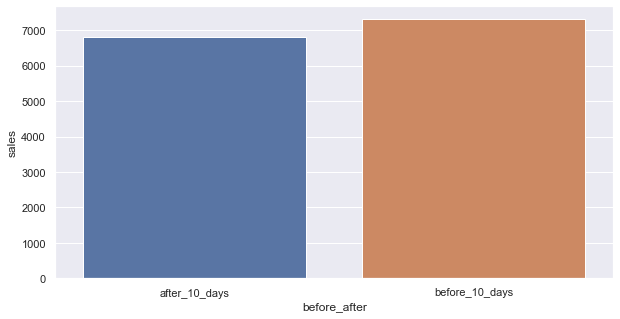

In [44]:
aux = df4[['day', 'sales']].groupby('day').mean().reset_index()

grid = GridSpec(2,2)
plt.figure(figsize=(20,10))

plt.subplot(grid[0,0])
sns.barplot(x='day', y='sales', data=aux);

plt.subplot(grid[1,0])
sns.regplot(x='day', y='sales', data=aux);

plt.subplot(grid[:,1])
sns.heatmap(aux.corr('pearson'), annot=True);

aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

aux2 = aux[['before_after', 'sales']].groupby('before_after').mean().reset_index()

grid = GridSpec(1,1)
plt.figure(figsize=(10,5))

plt.subplot(grid[0,0])
sns.barplot(x='before_after', y='sales', data=aux2);


### 4.2.9 H12. Lojas deveriam vender menos aos finais de semana.

Not precisely, stores sell less on saturdays but on sundays we see an increase on sells

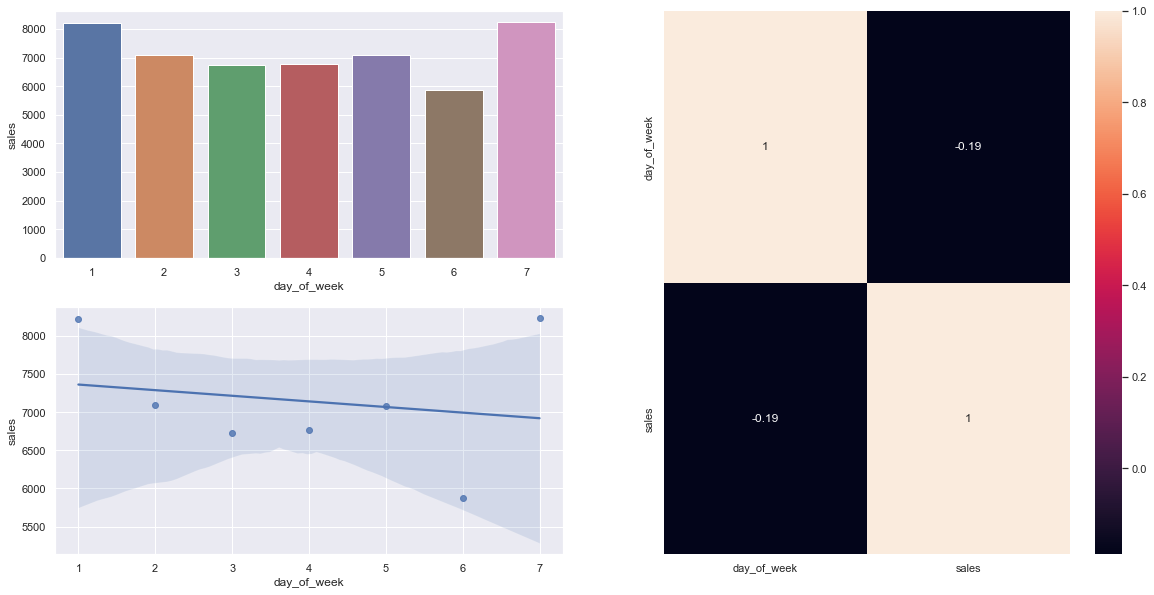

In [45]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

grid = GridSpec(2,2)
plt.figure(figsize=(20,10))

plt.subplot(grid[0,0])
sns.barplot(x='day_of_week', y='sales', data=aux);

plt.subplot(grid[1,0])
sns.regplot(x='day_of_week', y='sales', data=aux);

plt.subplot(grid[:,1])
sns.heatmap(aux.corr('pearson'), annot=True);

### 4.2.10 H13. Lojas deveriam vender menos durante os feriados escolares.

False, on average stores sells more in school holidays, except on September and December

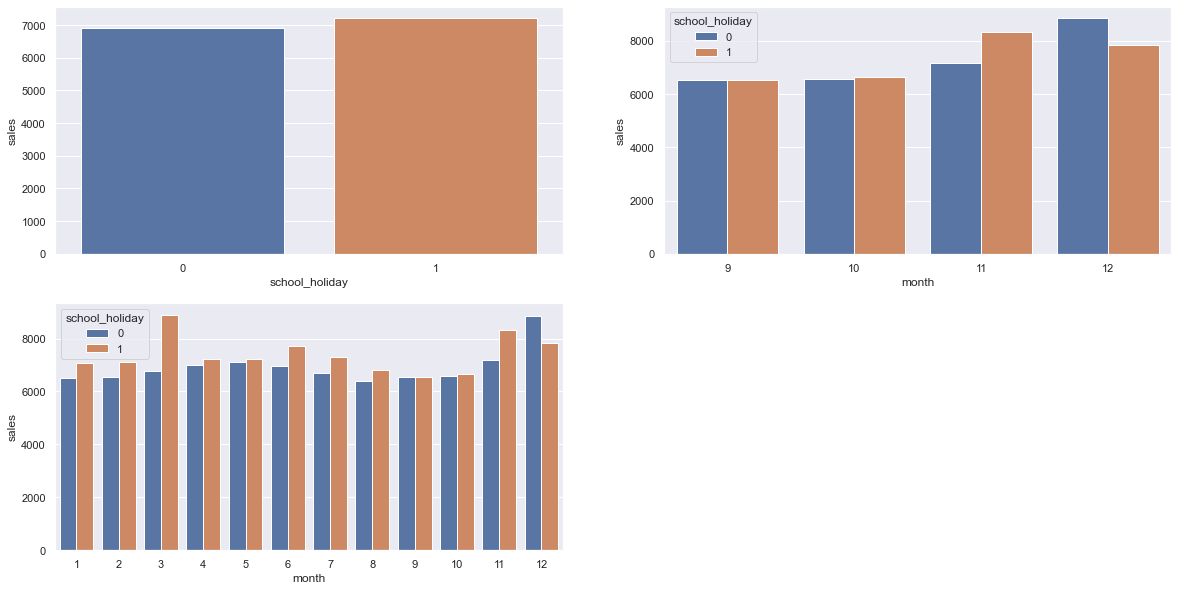

In [46]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()

aux2 = aux1[(aux1['month'] >= 9)]

grid = GridSpec(2,2)
plt.figure(figsize=(20,10))

plt.subplot(grid[0,0])
sns.barplot(x='school_holiday', y='sales', data=aux);

plt.subplot(grid[1,0])
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1);

plt.subplot(grid[0,1])
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);



### 4.3.1 Resumo das hipóteses

In [48]:
from tabulate import tabulate

In [54]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1 - Lojas com maior sortimentos deveriam vender mais', 'Verdadeira', 'Média'],
['H2 - Lojas com competidores mais próximos deveriam vender menos', 'Falsa', 'Baixa'],
['H3 - Lojas com promoções ativas por mais tempo deveriam vender mais', 'Verdadeira', 'Media'],
['H4 - Lojas com mais promoções consecutivas deveriam vender mais', 'Falsa', 'Alta'],
['H5', '-', '-'],
['H6 - Lojas abertas durante o feriado de Natal deveriam vender mais', 'Verdadeira', 'Alta'],
['H9 - Lojas deveriam vender mais ao longo dos anos', 'Inconclusiva', 'Alta'],
['H10 - Lojas deveriam vender mais no segundo semestre do ano', 'Verdadeira', 'Media'],
['H11 - Lojas deveriam vender mais depois do dia 10 de cada mês', 'Falsa', 'Alta'],
['H12 - Lojas deveriam vender menos aos finais de semana', 'Verdadeira', 'Alta'],
['H13 - Lojas deveriam vender menos durante os feriados escolares', 'Falsa', 'Alta'],
]
print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))


╒═════════════════════════════════════════════════════════════════════╤══════════════╤══════════════╕
│ Hipoteses                                                           │ Conclusao    │ Relevancia   │
╞═════════════════════════════════════════════════════════════════════╪══════════════╪══════════════╡
│ H1 - Lojas com maior sortimentos deveriam vender mais               │ Verdadeira   │ Média        │
├─────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H2 - Lojas com competidores mais próximos deveriam vender menos     │ Falsa        │ Baixa        │
├─────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H3 - Lojas com promoções ativas por mais tempo deveriam vender mais │ Verdadeira   │ Media        │
├─────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H4 - Lojas com mais promoções consecutivas deveriam vender mais     │ Falsa     

## 4.3 - Análise multivariada

### 4.3.1 Numerical attributes

<AxesSubplot:>

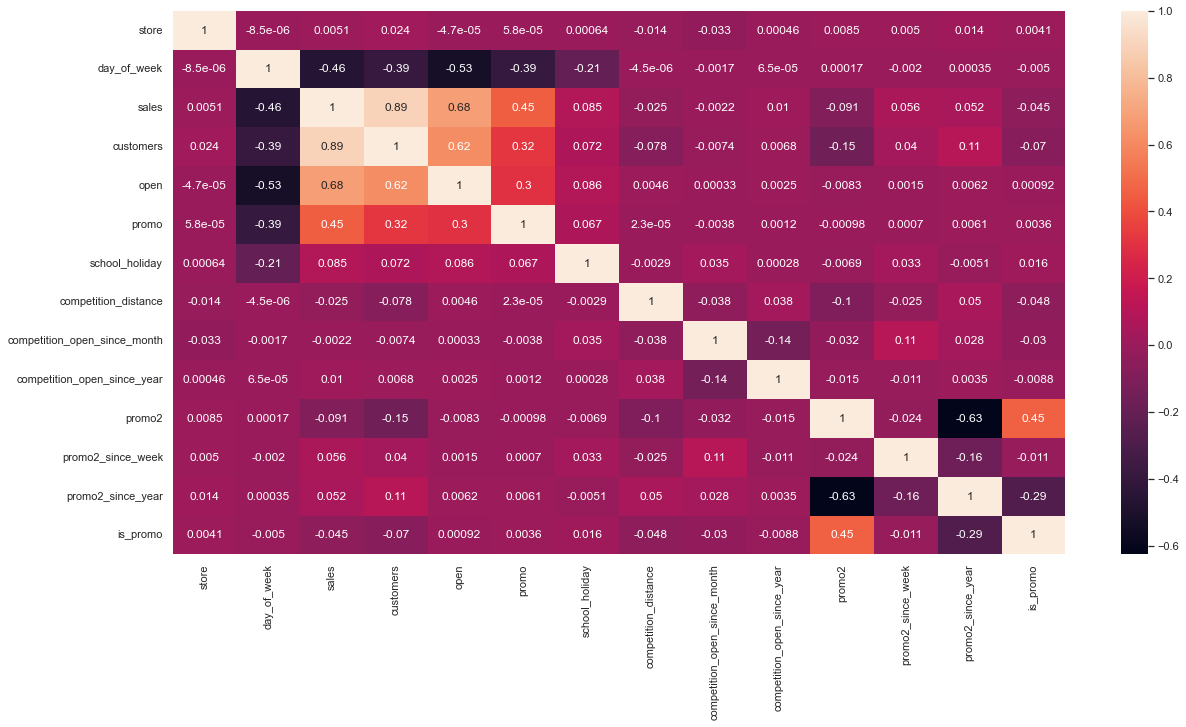

In [58]:
corr = num_attributes.corr(method='pearson')

plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True)

### 4.3.2 Categorical attributes

<AxesSubplot:>

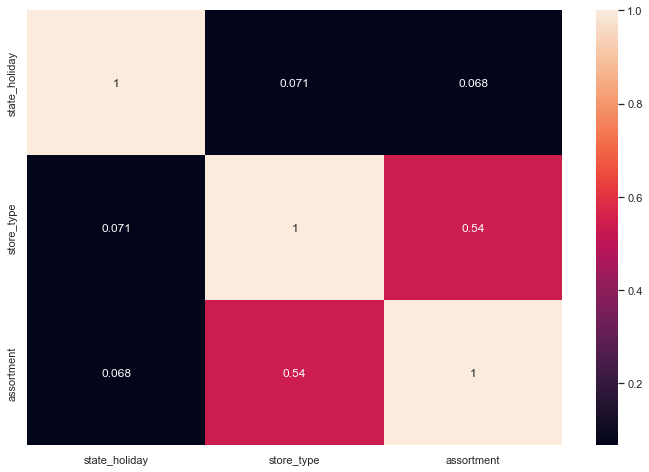

In [66]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

